In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [3]:
# experiments 
from experiments.run_sweep import run_sweep
from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation

from experiments.sweep_plots_helpper import taxi_training_plot_specs, taxi_evaluation_plot_specs


# environments
from environments.taxi_v3 import TaxiV3Config, get_taxi_v3_env

# SARSA confirmation bias agent
from agents.sarsa_td0_confirmation_bias import (
    SarsaTD0ConfirmationBiasConfig,
    SarsaTD0ConfirmationBiasAgent,
)

# metrics for training
from metrics.reward_mertrics import total_reward_per_episode, episode_won_taxi_v3, taxi_illegal_actions_per_episode
from metrics.frustration_metrics import (
    total_td_error_per_episode,
    mean_negative_td_error_per_episode,
    mean_absolute_td_error_per_episode,
    negative_td_error_sum_per_episode,
    frustration_rate_per_episode,
    tail_frustration_per_episode,
    cvar_tail_frustration_per_episode,
)

# external libraries
import numpy as np

ModuleNotFoundError: No module named 'experiments.run_experiment'

## Environments

In [3]:
env_config = TaxiV3Config()

## Agents

In [4]:
## Agents
# sarsa_td0 confirmation bias agent
agent_factory = SarsaTD0ConfirmationBiasAgent

sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won_taxi_v3": episode_won_taxi_v3,
        "taxi_illegal_actions_per_episode": taxi_illegal_actions_per_episode,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "mean_negative_td_error_per_episode": mean_negative_td_error_per_episode,
        "mean_absolute_td_error_per_episode": mean_absolute_td_error_per_episode,
        "negative_td_error_sum_per_episode": negative_td_error_sum_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

## Sweep configuration

In [5]:
base_train = TrainingConfig(
    name="TaxiV3_sarsa_td0",
    num_train_episodes=1000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="TaxiV3_sarsa_td0",
    num_eval_episodes=1000,  # use >0 if you want eval outputs
    env_kwargs={"config": env_config},
    evaluation_metrics={
        "total_reward_per_episode": total_reward_per_episode,
    },
)

In [6]:
# different q_tables
env = get_taxi_v3_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

## Confirmation bias results

In [7]:
# average (alpha_conf + alpha_disconf) / 2 = 0.2
confirmatory_pairs = [
    # (0.35, 0.05),
    # (0.30, 0.10),
    # (0.25, 0.15),
]

balanced_pairs = [
    (0.20, 0.20),
]

disconfirmatory_pairs = [
    # (0.15, 0.25),
    # (0.10, 0.30),
    # (0.05, 0.35),
]

alpha_pairs = confirmatory_pairs + balanced_pairs + disconfirmatory_pairs
seeds = list(range(1))  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "alpha_conf": a_conf,
            "alpha_disconf": a_disconf,
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for (a_conf, a_disconf) in alpha_pairs
        for seed in seeds
    ],
}

In [8]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_taxi_v3_env,
    agent_factory=agent_factory,
)


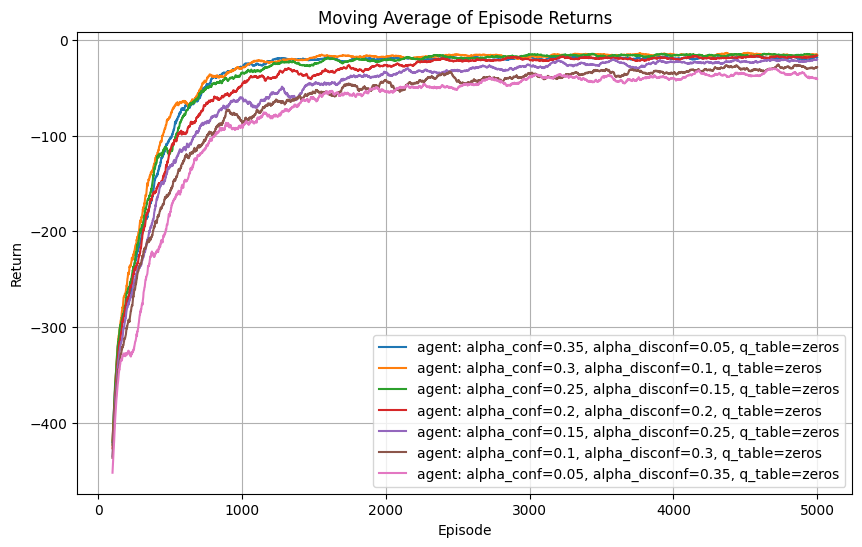

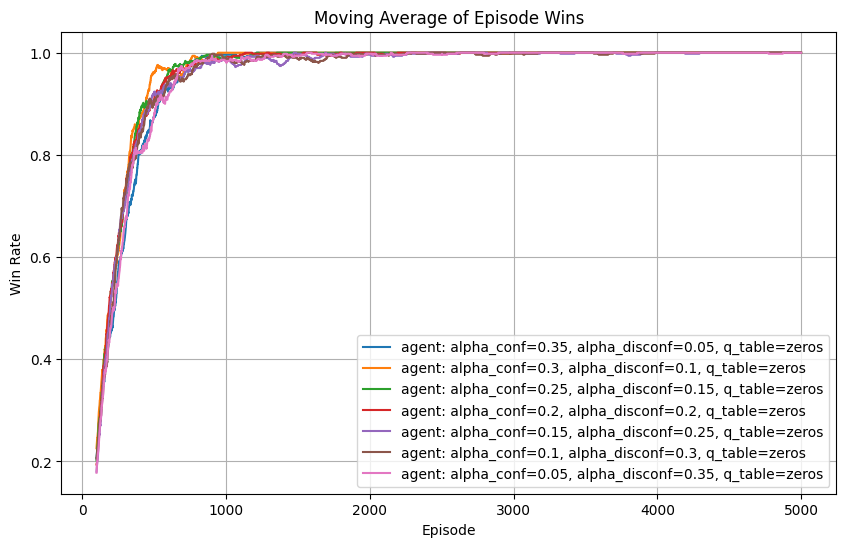

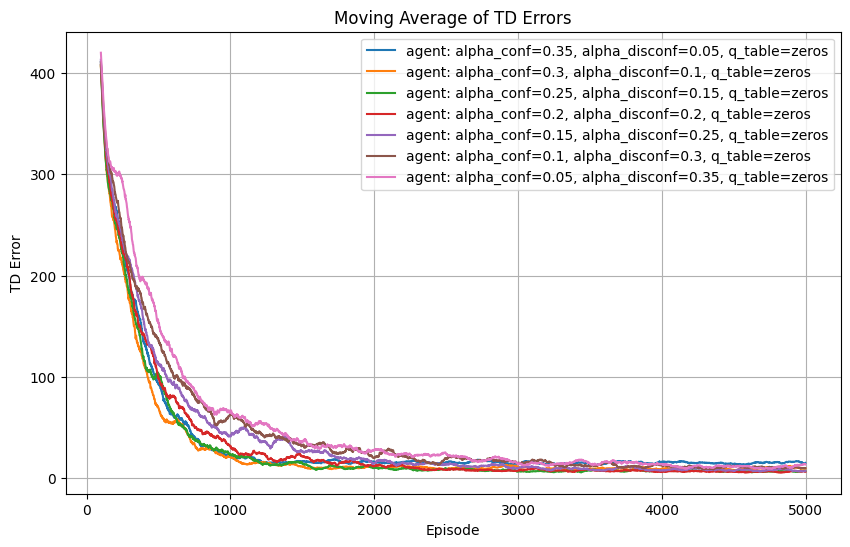

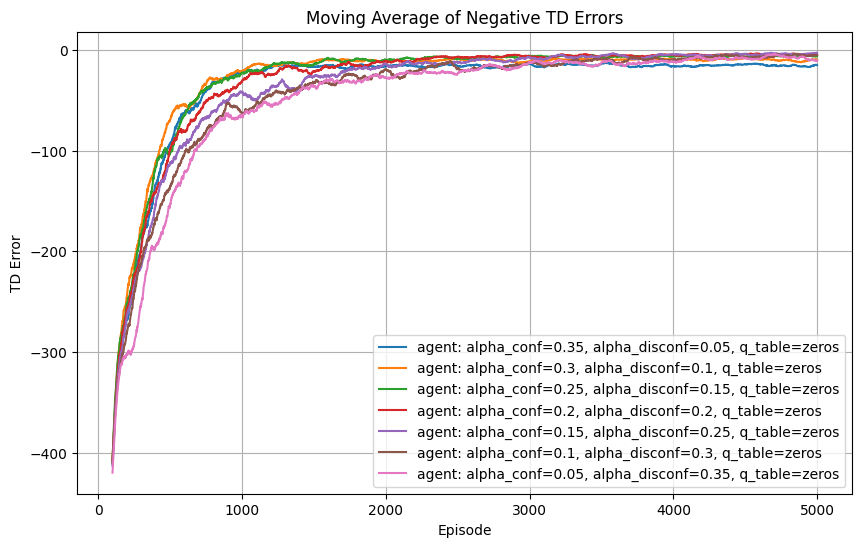

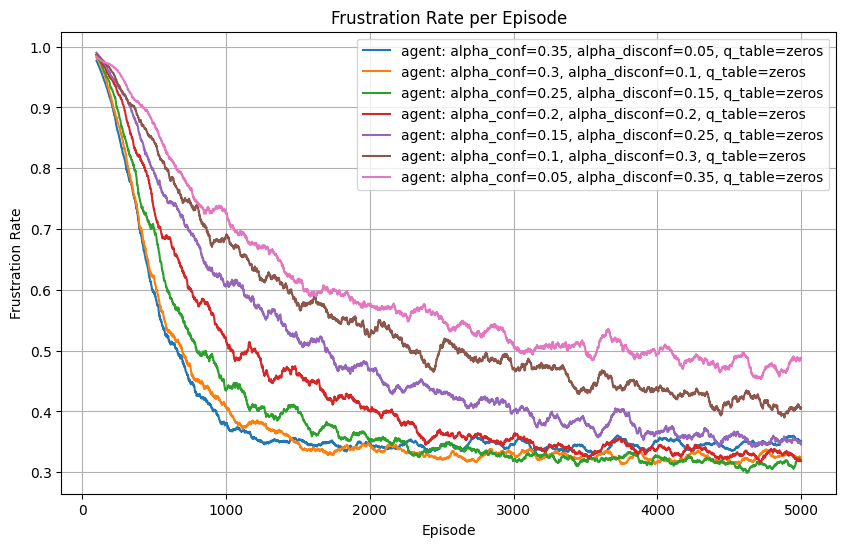

In [34]:
plot_sweep_training(results, window_size=100)

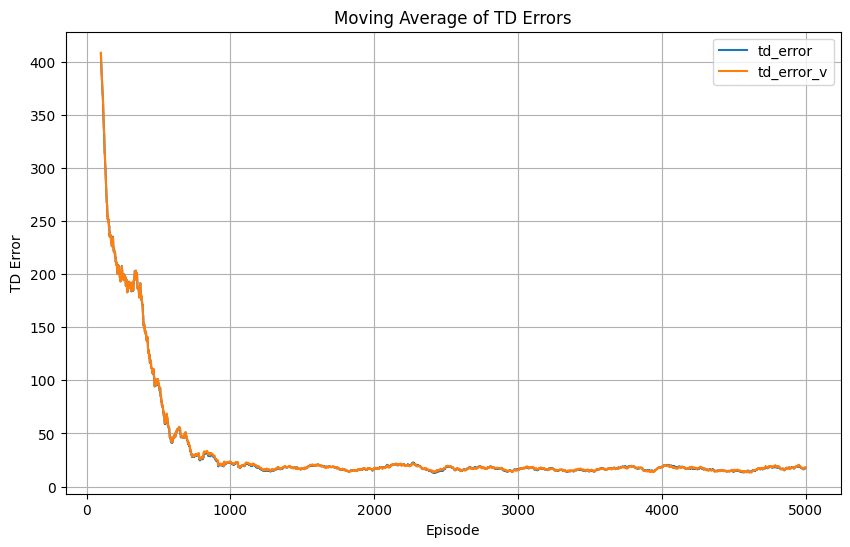

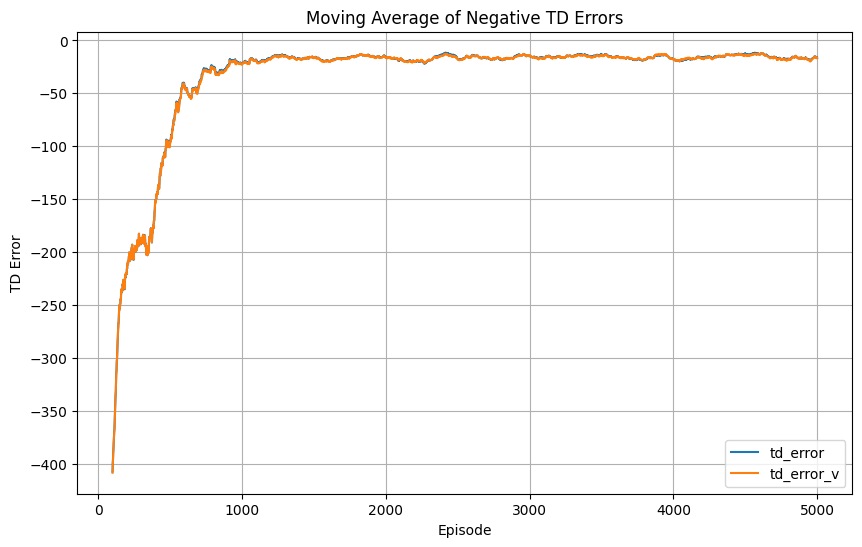

In [35]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


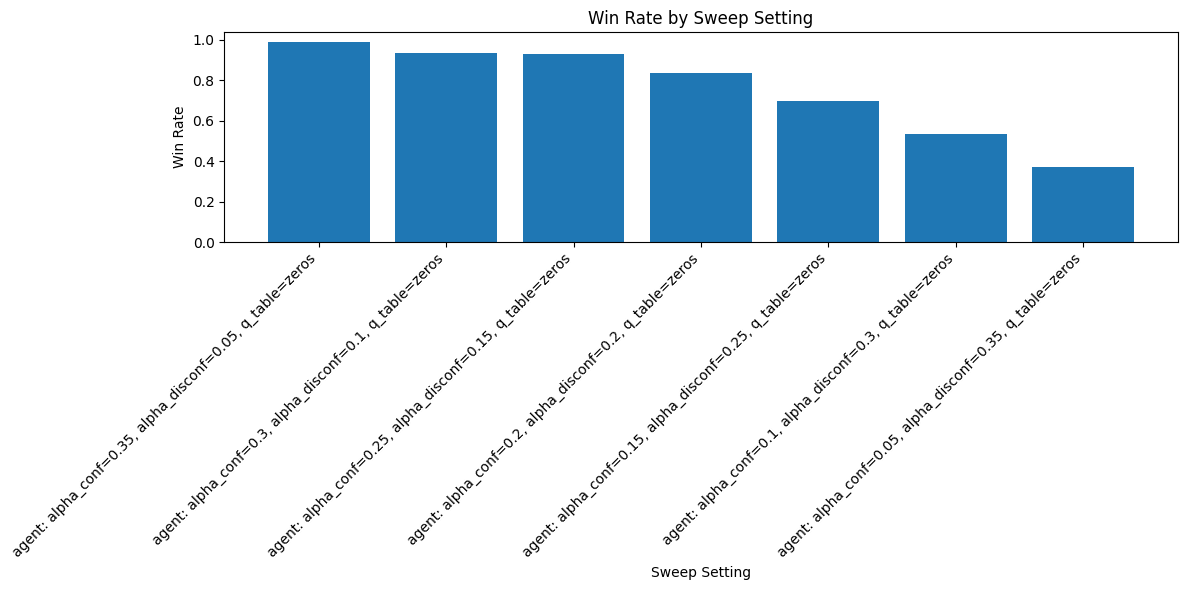

In [36]:
plot_sweep_evaluation(results)

## Positivity bias results

In [ ]:
# SARSA positivty bias agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0PositivityBiasConfig,
    SarsaTD0PositivityBiasAgent,
)

In [ ]:
def asymmetric_alphas(alpha_0: float, ratio: float) -> dict:
    """Return asymmetric step-sizes with a fixed mean and ratio."""
    if alpha_0 <= 0 or ratio <= 0:
        raise ValueError("alpha_0 and ratio must be > 0")

    alpha_negative = round((2.0 * alpha_0) / (ratio + 1.0), 4)
    alpha_positive = round(
        ratio * alpha_negative, 4
    )  # same as 2*alpha_0*ratio/(ratio+1)

    return {"alpha_positive": alpha_positive, "alpha_negative": alpha_negative}

In [4]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0PositivityBiasAgent

sarsa_td0_config = SarsaTD0PositivityBiasConfig(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.3,
    reward_metrics={
        "total_reward_per_episode": total_reward_per_episode,
        "episode_won": episode_won_taxi_v3,
    },
    td_error_metrics={
        "total_td_error_per_episode": total_td_error_per_episode,
        "frustration_rate_per_episode": frustration_rate_per_episode,
        "tail_frustration_per_episode": lambda td: tail_frustration_per_episode(
            td, percentile=0.90
        ),
        "cvar_tail_frustration_per_episode": lambda td: cvar_tail_frustration_per_episode(
            td, percentile=0.90
        ),
    },
)

In [5]:
base_train = TrainingConfig(
    name="TaxiV3_sarsa_td0",
    num_train_episodes=5000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="TaxiV3_sarsa_td0",
    num_eval_episodes=2000,
    env_kwargs={"config": env_config},
)

In [6]:
# different q_tables
env = get_taxi_v3_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [7]:
# mean alpha_0 = 0.2
a_0 = 0.2
ratios = [0.2, 0.5, 1.0, 2.0, 5.0]

seeds = list(range(5))

sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for r in ratios
        for seed in seeds
    ],
}

In [8]:
results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_taxi_v3_env,
    agent_factory=agent_factory,
)

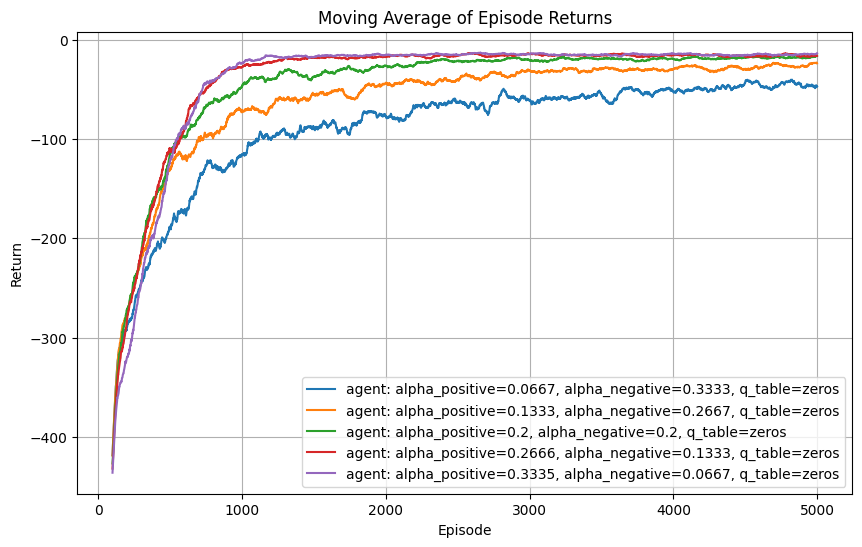

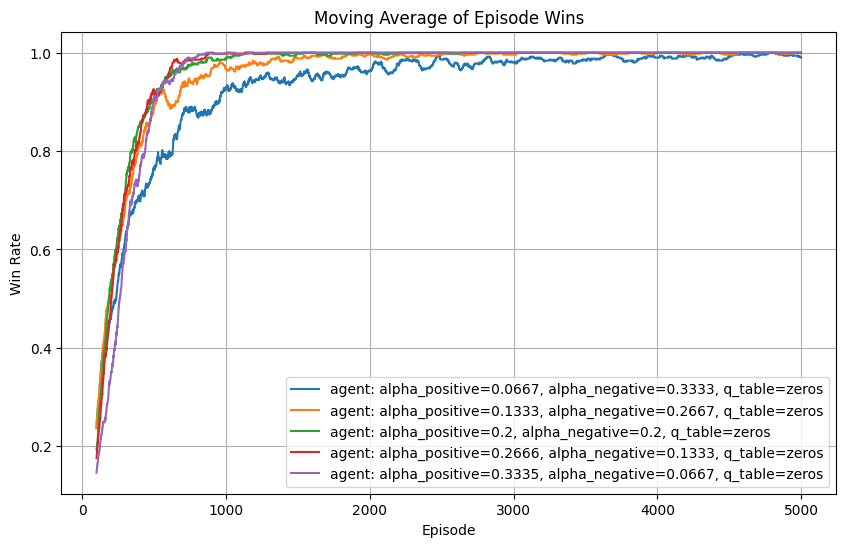

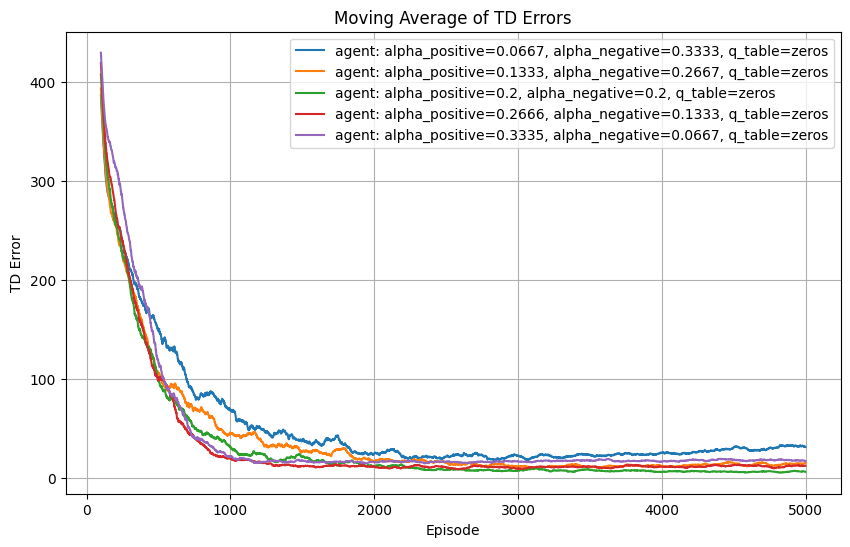

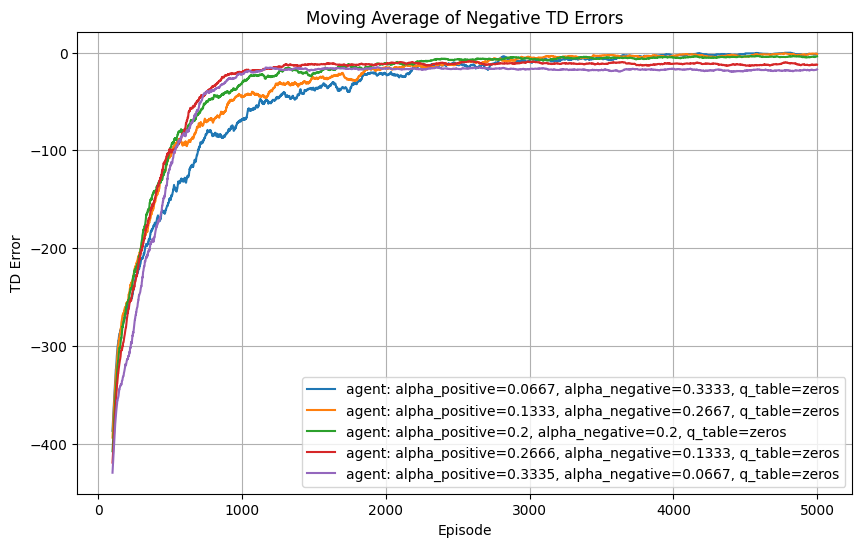

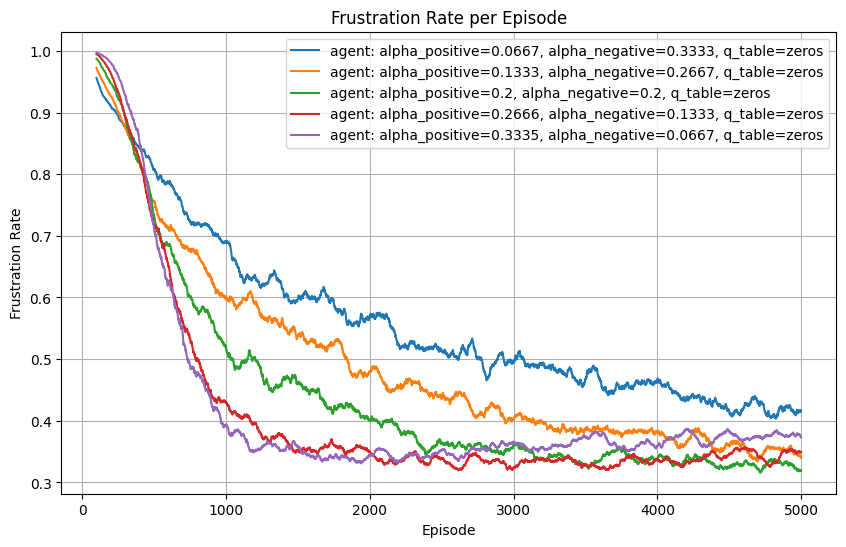

In [12]:
plot_sweep_training(results, window_size=100)

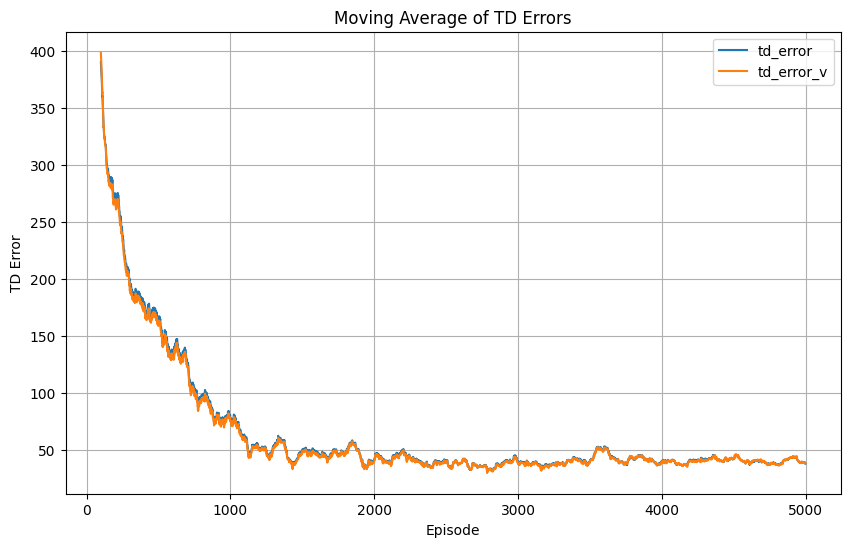

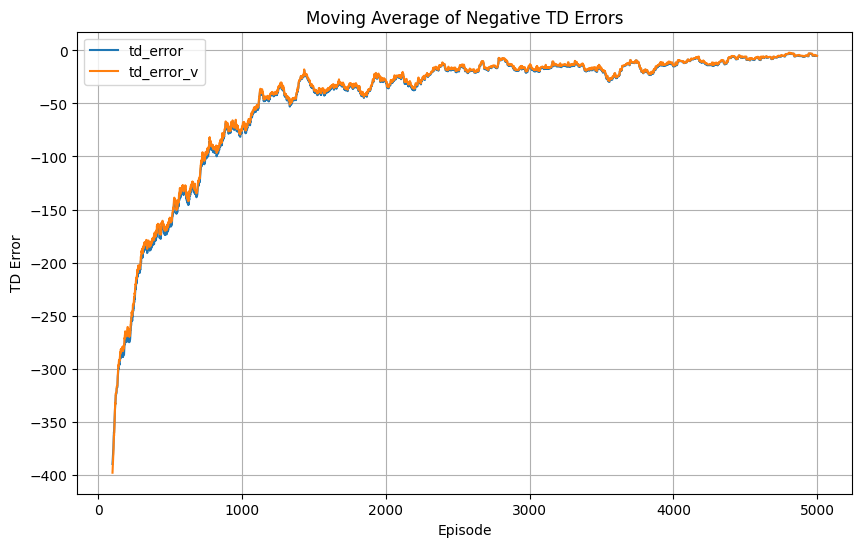

In [13]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)

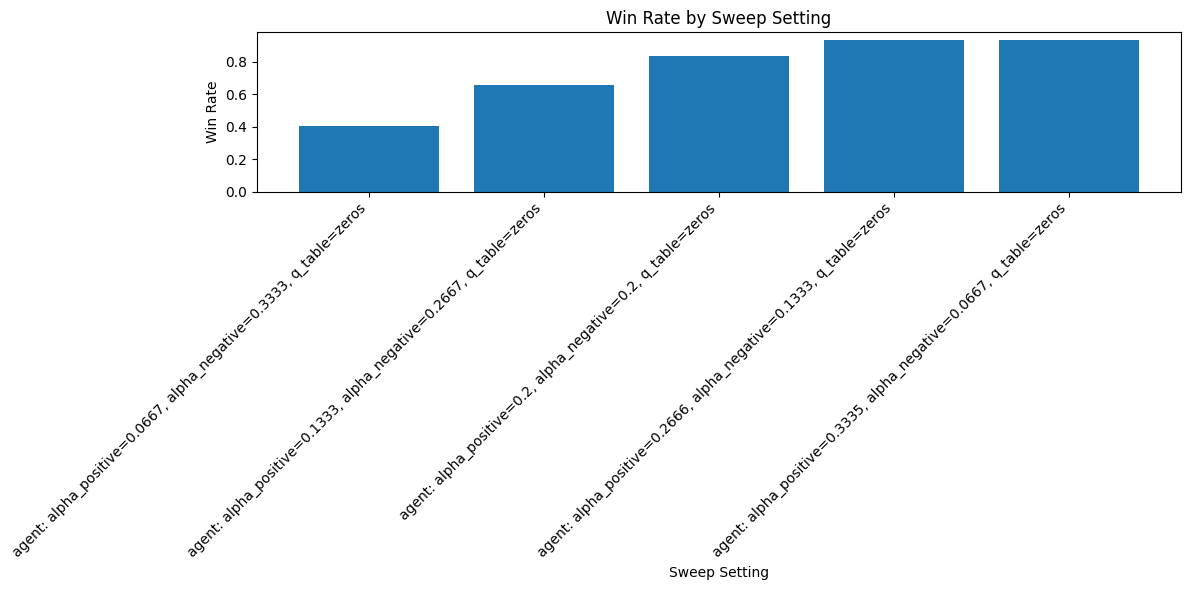

In [14]:
plot_sweep_evaluation(results)